In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
import re
plt.style.use('ggplot')

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPool1D, BatchNormalization, Dropout, LSTM, Embedding, GlobalMaxPool1D
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#read data from csv file to pandas dataframe
df = pd.read_csv('labeled_data.csv')

In [4]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
df.shape

(24783, 7)

In [6]:
#put relevant data into another dataframe
data = pd.DataFrame(columns=['label'])
data['label'] = df['class']
data['tweet'] = df['tweet']
data.head()

df_copy = data.copy()

df_copy['class'] = 0
df_copy.loc[(df_copy['label'] == 0), 'class'] = 'Hate speech'
df_copy.loc[(df_copy['label'] == 1), 'class'] = 'Offensive language'
df_copy.loc[(df_copy['label'] == 2), 'class'] = 'Neither'

df_copy.head()

,label,tweet,class
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neither
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive language
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive language
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive language
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive language


e:\nlp2\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='class', ylabel='count'>

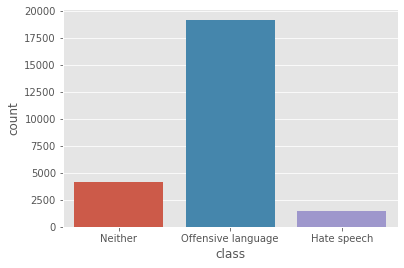

In [7]:
sns.countplot('class',data=df_copy)

In [8]:
#view class distribution
hate_tweets = data[data['label']==0]
offensive_tweets = data[data['label']==1]
neither = data[data['label']==2]
print(hate_tweets.shape)
print(offensive_tweets.shape)
print(neither.shape)

(1430, 2)
(19190, 2)
(4163, 2)


(11440, 2)
(12000, 2)
(12489, 2)


e:\nlp2\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='class', ylabel='count'>

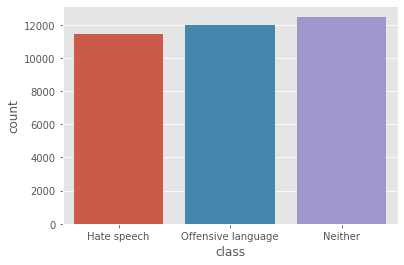

In [9]:
#balance the examples per class ( hate tweets x8, offensive tweet take just first 12000 examples, neither x3)
hate_tweets = pd.concat([hate_tweets, hate_tweets, hate_tweets, hate_tweets, hate_tweets, hate_tweets, hate_tweets, hate_tweets],ignore_index = True)
neither = pd.concat([neither,neither,neither], ignore_index = True)
offensive_tweets = offensive_tweets.iloc[0:12000,:]
print(hate_tweets.shape)
print(offensive_tweets.shape)
print(neither.shape)
data = pd.concat([hate_tweets,offensive_tweets,neither],ignore_index = True)
data.shape

df_copy = data.copy()

df_copy['class'] = 0
df_copy.loc[(df_copy['label'] == 0), 'class'] = 'Hate speech'
df_copy.loc[(df_copy['label'] == 1), 'class'] = 'Offensive language'
df_copy.loc[(df_copy['label'] == 2), 'class'] = 'Neither'

sns.countplot('class',data=df_copy)

In [10]:
new_tweet = []
stop_words = stopwords.words('english')
stop_words.append('rt')
stop_words.append('amp')
lemmatizer = WordNetLemmatizer()
url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|' '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'

In [11]:
for index, row in data.iterrows():
    tweet = row['tweet']
    tweet = re.sub('"', "", tweet)
    tweet = re.sub(mention_regex, ' ',tweet) #remove all usernames
    tweet = re.sub(url_regex, ' ', tweet)  #remove the urls
    tweet = tweet.lower() #lowercasing
    tweet = re.sub("[^a-z]+", " ", tweet) #remove all numbers and special chars
    tweet = tweet.split()
    tweet = [word for word in tweet if not word in stop_words] #remove stopwords
    tweet = [lemmatizer.lemmatize(token) for token in tweet] #lemmatize
    tweet = [lemmatizer.lemmatize(token, "v") for token in tweet]
    tweet = " ".join(tweet)
    new_tweet.append(tweet)
data['new'] = new_tweet #add clean tweets to a new column in the dataframe


In [12]:
data.head()[4:]

,label,tweet,new
4,0,"""@NoChillPaz: ""At least I'm not a nigger"" http...",least nigger lmfao


In [13]:
#visualise word frequency in each class
hate_words = ' '.join(data[data.label == 0].new.values)
offensive_words = ' '.join(data[data.label == 1].new.values)
neither_words = ' '.join(data[data.label == 2].new.values)

Text(0.5, 1.0, 'Hate Words')

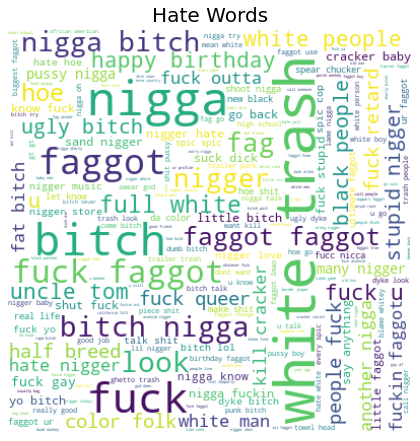

In [14]:
plt.figure(figsize=(16, 8))
cloud1 = WordCloud(width=400, height=400, background_color='white').generate(hate_words)
plt.subplot(121)
plt.imshow(cloud1, interpolation="bilinear")
plt.axis("off")
plt.title('Hate Words', size=20)

Text(0.5, 1.0, 'Offensive Words')

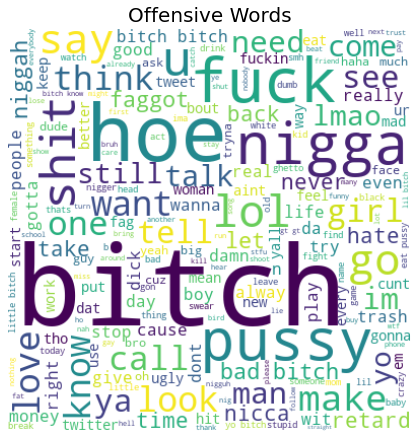

In [15]:
plt.figure(figsize=(16, 8))
cloud2 = WordCloud(width=400, height=400, background_color='white').generate(offensive_words)
plt.subplot(122)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.title('Offensive Words', size=20)

Text(0.5, 1.0, 'Neither Words')

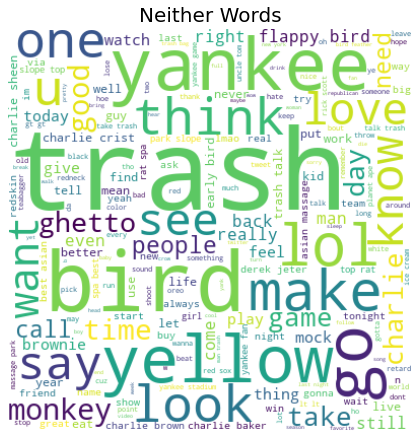

In [16]:
plt.figure(figsize=(16, 8))
cloud3 = WordCloud(width=400, height=400, background_color='white').generate(neither_words)
plt.subplot(122)
plt.imshow(cloud3, interpolation="bilinear")
plt.axis("off")
plt.title('Neither Words', size=20)

In [17]:
#feature extraction
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=10)
features = vectorizer.fit_transform(data.new).toarray()
print(features.shape)

(35929, 5576)


In [18]:
#split data
X_train, X_test, y_train, y_test = train_test_split(features, data.label,test_size = 0.05)

In [19]:
# #grid search for LogisticRegression
# params = {'penalty': ['l1', 'l2'], 'C': [1, 3, 5, 10]}
# clf = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=150), param_grid=params, scoring='accuracy', cv=5, n_jobs=-1)
# clf.fit(X_train, y_train)
# print("Best parameters found were {} with an accuracy of {:.2f}".format(
#     clf.best_params_,
#     clf.best_score_
# ))


0.9515859766277128
1797


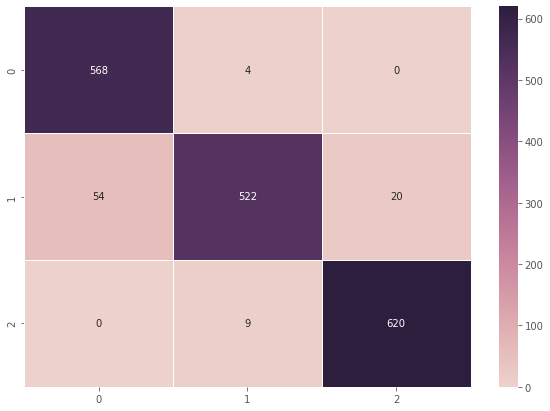

In [20]:
#Logistic Regression
lr = LogisticRegression(solver='liblinear', penalty='l1',C = 10)
lr.fit(X_train,y_train)
y_predicted = lr.predict(X_test)
score = lr.score(X_test,y_test)
print(score)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_predicted), index=[0,1,2], columns=[0,1,2])
print(sum(sum(confusion_matrix(y_test, y_predicted))))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

In [21]:
#Sequence + tokanization 
x= data['new']
y= data['label']
num_words = x.shape[0]
embed_dim = 32
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x)
length=[]
for i in sequences:
    length.append(len(i))
print("Max is: ",np.max(length))

Max is:  27


In [22]:
#Adding padding for Deep Learning model
sequences = pad_sequences(sequences, padding = 'post')

In [23]:
#Split the data
x_train,x_valid,y_train,y_valid = train_test_split(sequences,y,test_size = 0.05)

In [24]:
#model
def build_model(nr_labels, length):
    model = Sequential()
    model.add(Embedding(num_words, embed_dim, input_length = length))
    model.add(LSTM(32, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nr_labels, activation='sigmoid'))
    return model

def build_compiled_model(length):
    model = build_model(nr_labels=3, length = length)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = build_compiled_model(np.max(length))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 32)            1149728   
                                                                 
 lstm (LSTM)                 (None, 27, 32)            8320      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [25]:
#train model
history = model.fit(x=x_train, y=y_train, epochs=10, validation_data=(x_valid, y_valid), shuffle=True)

Epoch 1/10
1067/1067 [==============================] - 9s 6ms/step - loss: 0.4355 - accuracy: 0.8278 - val_loss: 0.2361 - val_accuracy: 0.9171
Epoch 2/10
1067/1067 [==============================] - 7s 7ms/step - loss: 0.1829 - accuracy: 0.9401 - val_loss: 0.2020 - val_accuracy: 0.9354
Epoch 3/10
1067/1067 [==============================] - 7s 7ms/step - loss: 0.1264 - accuracy: 0.9605 - val_loss: 0.1708 - val_accuracy: 0.9432
Epoch 4/10
1067/1067 [==============================] - 7s 6ms/step - loss: 0.0945 - accuracy: 0.9702 - val_loss: 0.1752 - val_accuracy: 0.9494
Epoch 5/10
1067/1067 [==============================] - 7s 6ms/step - loss: 0.0721 - accuracy: 0.9778 - val_loss: 0.1752 - val_accuracy: 0.9488
Epoch 6/10
1067/1067 [==============================] - 7s 6ms/step - loss: 0.0562 - accuracy: 0.9829 - val_loss: 0.1603 - val_accuracy: 0.9533
Epoch 7/10
1067/1067 [==============================] - 7s 6ms/step - loss: 0.0476 - accuracy: 0.9850 - val_loss: 0.1626 - val_accuracy:

In [26]:
#make predictions
y_pred = np.argmax(model.predict(x_valid), axis=1)

On validation data:
Accuracy: 0.95


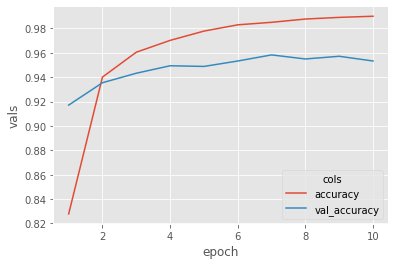

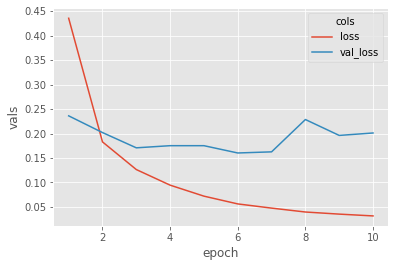

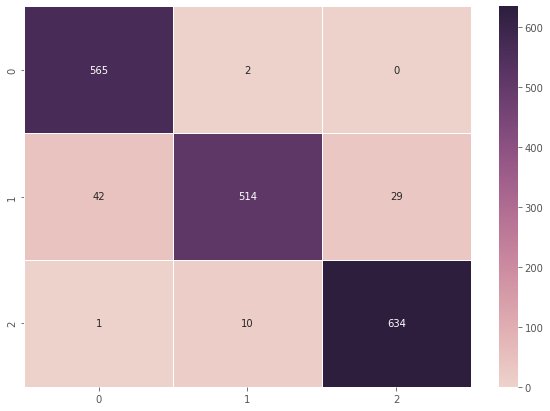

In [27]:
print('On validation data:')
print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

# plot graphs
metrics_df = pd.DataFrame(history.history).reset_index().rename(columns={"index": "epoch"})
metrics_df['epoch'] = metrics_df['epoch'] + 1
acc_df = metrics_df[['epoch', 'accuracy', 'val_accuracy']].melt('epoch', var_name='cols', value_name='vals')
loss_df = metrics_df[['epoch', 'loss', 'val_loss']].melt('epoch', var_name='cols', value_name='vals')
sns.lineplot(data=acc_df, x='epoch', y='vals', hue='cols')
plt.show()
sns.lineplot(data=loss_df, x='epoch', y='vals', hue='cols')
plt.show()

# plot confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_valid, y_pred), index=[0,1,2], columns=[0,1,2])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()